# Two-Fluids SBN

In [1]:
import os
from scipy import *
from numpy import *
from pylab import *
import arrayfire as af
from core_libs.bindings import *
from core_libs.af_loader import *
from scipy import fftpack
from scipy import special
from matplotlib.pyplot import *
%matplotlib widget

# Parameters of the fluid

https://www.overleaf.com/2698295917wfpdqgytnfmm

In [42]:
#light fluid wavelength
lf=532*10**-9


#k_fluid
kf = (2*pi)/(lf)

#parameters of the crystal
ne = 2.36 #index of refraction n_e
r33=235*10**-12 #pm/V
#Biasing electric Field
E0=1400*10**2 # V/m

#maximum index variation
delta_n_max = 0.5*ne**3*r33*E0
delta_n=delta_n_max

#simulation beam power
If1= 7.9 #mw/cm^-2
If2 = 150 #mw/cm^-2
Isat = 50/If1 #mw/cm^-2


#absorption
alpha = 100 /(delta_n_max * kf) #1.319 cm^-2
gamma = 1

#healing length
hl = 1/(kf*sqrt(ne*delta_n))

#transverse direction scaling factor
factor_t = kf*sqrt(ne*delta_n)

#propagation direction scaling factor
factor_z = kf*delta_n

##################################################
#Crystal Size
lx=2.5*10**-3
ly=2.5*10**-3
lz=20*10**-3

#in adimensional units
lx_sim = factor_t*lx
ly_sim = factor_t*ly
lz_sim = factor_z*lz

##################################################

d1=45*10**-6*factor_t
d2=90*10**-6*factor_t

Vmax = -1.0*10**-4/delta_n
vel_max = 1/(sqrt(ne)*sqrt(delta_n))

print("delta_n -> " + str(delta_n))
print("lx -> " + str(lx_sim))
print("ly -> " + str(ly_sim))
print("lz -> " + str(lz_sim))
print("d in between " + str(d1) + ' to ' + str(d2))
print("V_max -> "+ str(Vmax))
print('vel_max - > ' + str(vel_max))
print('healing length - > ' + str(hl))

delta_n -> 0.0002162230112
lx -> 666.9836711655042
ly -> 666.9836711655042
lz -> 51.074031843833346
d in between 12.005706080979074 to 24.011412161958148
V_max -> -0.4624854655617709
vel_max - > 44.26832023139345
healing length - > 3.7482176971910518e-06


In [3]:
700/5e-3

140000.0

## Start a simulation mesh
Define the simulation box parameters

In [4]:
#number of transversal dimensions (only working 1 and 2, necessary for plotting)
dims = 2

#Number of points in x,y transversal dimensions
Nx = 512
Ny = 512

#do not change Nt, Nz
Nt = 1 
Nz = 1

#spatial steps
dx = lx_sim / Nx
dy = ly_sim / Ny
dt = 1.
print('dx->',dx,'dy->',dy)

#integration parameters


stride = 50
dz = 0.1 #.2
total_steps = int(lz_sim/(stride*dz))
print(total_steps)

#define a directory to save
saveDir = "turbulence_photorefractive5"



dx-> 1.3027024827451255 dy-> 1.3027024827451255
10


## Initial condition
Define the initial condition

In [5]:
#a simple gaussian function in 2d
def gaussian_2d_field(x_af,y_af,A,w,x0,y0,vx,vy):
    new_field = A*af.exp(-((x_af - x0)*(x_af - x0)+ (y_af - y0)*(y_af - y0)) / 
                                    (w*w))*af.exp(1.0j*(vx*(x_af-x0)+ vy*(y_af-y0)))
    return new_field


def gaussian_2d_field_int(x_af,y_af,A,w,x0,y0,vx,vy):
    new_field = A*af.exp(-2*((x_af - x0)*(x_af - x0)+ (y_af - y0)*(y_af - y0)) / 
                                    (w*w))*af.exp(1.0j*(vx*(x_af-x0)+ vy*(y_af-y0)))
    return new_field


#a simple gaussian function in 2d
def bessel_2d_field(x_af,y_af,A,w,x0,y0):
    r=af.sqrt(((x_af - x0)*(x_af - x0)+ (y_af - y0)*(y_af - y0))/ (w*w))
    new_field = special.jv(0,r)
    return new_field

def snake(A,x_af,y_af,x0,delta):
    new_field = A
    #new_field+= -A*(x_af<(x0+delta))*(x_af>(x0-delta))
    new_field+= -2*A*(x_af>(x0+delta))
    return new_field

def planewave_2d_field(x_af,y_af,A,vx):
    new_field = A*af.exp(1.0j*(vx*(x_af)))
                         
    return new_field

def whitenoise_2d_field(x_af,A):
    new_field = A*af.randu(my_simulation.x_af.dims()[0],my_simulation.x_af.dims()[1])*af.exp(1.0j*2*pi*af.randu(my_simulation.x_af.dims()[0],my_simulation.x_af.dims()[1]))
                         
    return new_field

def bessel_2d_field(x_af,y_af,A,x0,y0,d):
    v = linspace(0,2*pi,1000)
    dv = v[1] - v[0]
       
    fz = 2.4048
    fs = fz / (d/2)
    
    r = af.sqrt((x_af-x0)*(x_af-x0) + (y_af-y0)*(y_af-y0))
    resultado = fs*r
    
    my_field = resultado*0.
    for k in v:
        my_field += af.exp(1.0j * resultado * np.cos(k))*dv
       
    return (A*(af.pow(af.abs(my_field)/(2*pi),2))) # * (r <= 2*d)


#nxx=30
#vx_planewave = 2*pi * nxx / (Nx*dx)#setting a planewave requires a multiple of 2pi/Lx due to native periodic boundary conditions
#print("vx_planewave = " + str(vx_planewave))



## Define the nonlinear parameters
Type number and type vector.

In [6]:
af.device.set_device(0)
af.device.device_info()

{'device': 'NVIDIA_GeForce_840M',
 'backend': 'CUDA',
 'toolkit': 'v9.2',
 'compute': '5.0'}

In [48]:
#Simulation parameters

waist_sim = 650*10**-6 * factor_t

dd = 115.3*10**-6*factor_t #bessel
dd2 = 239*10**-6*factor_t #bessel

cs = np.sqrt(1/Isat)
vx = 1.5 * cs
gamma = 1


print("vx = " + str(vx))

print("bessel diameter = " + str(dd))

my_simulation = simulation_config(dims, Nx, Ny, Nt, Nz, total_steps, 
                                  stride,dx,dy,dz,dt,0,0, 
                                  alpha, Isat, gamma, saveDir)

my_simulation.initial_condition.add_field(gaussian_2d_field(my_simulation.x_af,my_simulation.y_af,1.,waist_sim,
                                                                Nx*dx/2,Ny*dy/2,vx,0))

# my_simulation.initial_condition2.add_field(gaussian_2d_field(my_simulation.x_af,my_simulation.y_af,1.,waist_sim,
#                                                                 Nx*dx/2,Ny*dy/2,0,0))

# my_simulation.initial_condition.add_field(gaussian_2d_field_int(my_simulation.x_af,my_simulation.y_af,1.,waist_sim,
#                                                                 Nx*dx/2,Ny*dy/2,vx,
#                                                                 0)*snake(1,my_simulation.x_af,my_simulation.y_af,
#                                                                          20*Nx*dx/40,1))

my_simulation.initial_condition.add_field(whitenoise_2d_field(my_simulation.x_af,0.2))

my_simulation.initial_condition2.add_field(bessel_2d_field(my_simulation.x_af,my_simulation.y_af,np.sqrt(If2),
                                    my_simulation.Nx*dx/2,my_simulation.Ny*dy/2,dd))
my_simulation.initial_condition2.add_field(bessel_2d_field(my_simulation.x_af,my_simulation.y_af,np.sqrt(If2),
                                    my_simulation.Nx*dx/2,my_simulation.Ny*dy/2,dd2))

#my_simulation.initial_condition2.add_field(gaussian_2d_field(my_simulation.x_af,my_simulation.y_af,np.sqrt(If2),dd/2,
#                                                                Nx*dx/2,Ny*dy/2,0,0))


#define the nonlinearities of type number

#how many
number_nl_numbers = 0
#(g, power)
nl_numbers = []
my_simulation.number_nl_numbers = number_nl_numbers

#define the nonlinearities of type vector
#how many
number_nl_vectors = 0
nl_vectors=[]
my_simulation.number_nl_vectors = number_nl_vectors

vx = 0.5962382074305538
bessel diameter = 30.761286914153054


## Plot initial Conditions

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
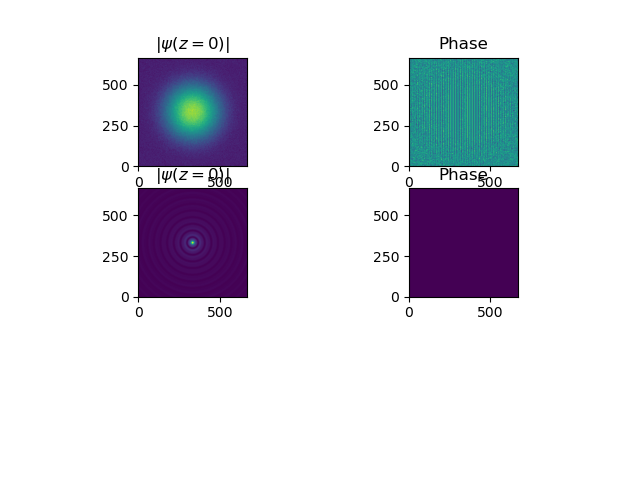

In [49]:
#%matplotlib notebook
#plotting a planewave appears wild due to the colorbar
plt.clf()
my_simulation.plot()

plt.show()

## Generate the configuration file

In [50]:
my_simulation.gen_config_file(nl_numbers,nl_vectors)

**Configuring Mesh:
Config folder already exists, skipping mkdir
Configuration file created!
**Configuring Initial Conditions
Initial condition file created!
**Configuring nonlinearities:
Nonlinearities configuration files created!


## Run simulation

Having the engine built previously and added to the folder we can call from the command line to execute it.

Options:

First argument corresponds to backend: 1 - CPU; 2 - OpenCl; 3 - CUDA;

Second argument corresponds to device: 0 - #number of devices available to choose the device

In [51]:
%%cmd
envelope.exe 2 0

Microsoft Windows [Version 10.0.19044.1645]
(c) Microsoft Corporation. All rights reserved.

(LAB_env) C:\Users\Tiago Ferreira\OneDrive - INESC TEC\Doutoramento\PhD_repository\Python\SBN_simulations\SBN>envelope.exe 2 0
ArrayFire v3.6.1 (OpenCL, 64-bit Windows, build b443e14)
[0] NVIDIA: NVIDIA GeForce 840M, 2047 MB
-1- INTEL: Intel(R) HD Graphics 4600, 1982 MB
-2- INTEL: Intel(R) Core(TM) i7-4700MQ CPU @ 2.40GHz, 12220 MB
Running info
ArrayFire v3.6.1 (OpenCL, 64-bit Windows, build b443e14)
[0] NVIDIA: NVIDIA GeForce 840M, 2047 MB
-1- INTEL: Intel(R) HD Graphics 4600, 1982 MB
-2- INTEL: Intel(R) Core(TM) i7-4700MQ CPU @ 2.40GHz, 12220 MB
Creating a mesh for our problem 
---Mesh created--- 
---scalar field created--- 
---start--- 
Stride 0 of 10
update Stride 1 of 10
update Stride 2 of 10
update Stride 3 of 10
update Stride 4 of 10
update Stride 5 of 10
update Stride 6 of 10
update Stride 7 of 10
update Stride 8 of 10
update Stride 9 of 10
update Total elapsed time 	37874

(LAB_env) C:

## Data Analysis

In [52]:
#load the simulation mesh - here we use the data generated , deprecating the previous generated data; 
#they are equivalent, but this way you can adapt the same codes to simulations generated from pure c++ simulations

#load the simulation mesh
my_mesh = mesh(saveDir+"/")

#load the data from data folder
#stride between consecutive loaded files
stride_read = 1
simulation_data,zs = load_data_folder(saveDir+"/gnlse_field/",my_mesh,stride_read)
simulation_data2,zs = load_data_folder(saveDir+"/gnlse_field2/",my_mesh,stride_read)

# a) Plot the Results at step = 20

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
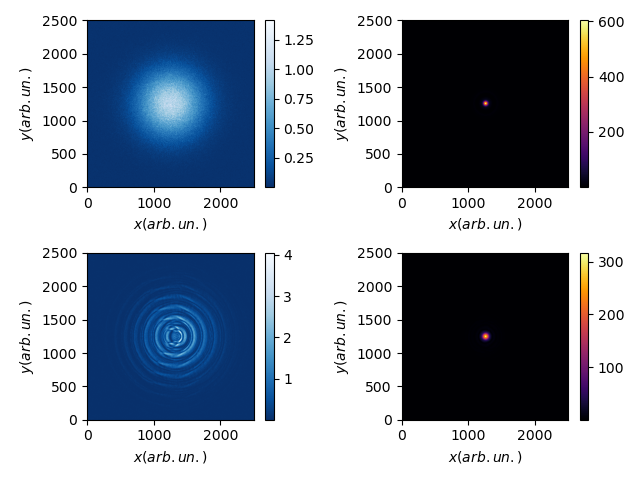

In [53]:
fig, ax = subplots()


subplot(2,2,1)
im = imshow(transpose(abs(simulation_data[0])**2), origin = "lower", extent = [0, my_mesh.lx*hl*1e6,0,my_mesh.ly*hl*1e6], 
       aspect = my_mesh.dx/my_mesh.dy, cmap = 'Blues_r')
xlabel(r"$x (arb.un.)$")
ylabel(r"$y (arb.un.)$")
colorbar(im)

subplot(2,2,2)
im1 = imshow(transpose(abs(simulation_data2[0])**2), origin = "lower", extent = [0, my_mesh.lx*hl*1e6,0,my_mesh.ly*hl*1e6], 
       aspect = my_mesh.dx/my_mesh.dy, cmap = cm.inferno)
xlabel(r"$x (arb.un.)$")
ylabel(r"$y (arb.un.)$")
colorbar(im1)

subplot(2,2,3)
im = imshow(transpose(abs(simulation_data[-1])**2), origin = "lower", extent = [0, my_mesh.lx*hl*1e6,0,my_mesh.ly*hl*1e6], 
       aspect = my_mesh.dx/my_mesh.dy, cmap = 'Blues_r')
xlabel(r"$x (arb.un.)$")
ylabel(r"$y (arb.un.)$")
colorbar(im)

subplot(2,2,4)
im1 = imshow(transpose(abs(simulation_data2[-1])**2), origin = "lower", extent = [0, my_mesh.lx*hl*1e6,0,my_mesh.ly*hl*1e6], 
       aspect = my_mesh.dx/my_mesh.dy, cmap = cm.inferno)
xlabel(r"$x (arb.un.)$")
ylabel(r"$y (arb.un.)$")
colorbar(im1)

fig.tight_layout()



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
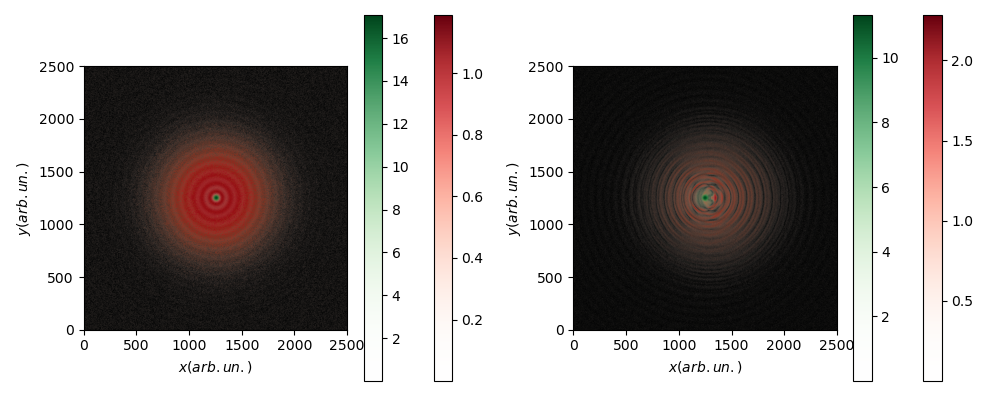

In [22]:
fig, ax = subplots(figsize=[10,4])

from matplotlib.colors import ListedColormap
cmap = cm.Reds
new_cmap = cmap(np.arange(cmap.N))
#set transparency channel
new_cmap[:,-1] = np.linspace(0.0,1,cmap.N)
new_cmap = ListedColormap(new_cmap)

cmap = cm.Greens
new_cmap2 = cmap(np.arange(cmap.N))
#set transparency channel
new_cmap2[:,-1] = np.linspace(0.0,1,cmap.N)
new_cmap2 = ListedColormap(new_cmap2)

subplot(1,2,1)

im = imshow(transpose(0*abs(simulation_data[0])), origin = "lower", extent = [0, my_mesh.lx*hl*1e6,0,my_mesh.ly*hl*1e6], 
       aspect = my_mesh.dx/my_mesh.dy, cmap = cm.Greys_r)

im = imshow(transpose(abs(simulation_data[0])), origin = "lower", extent = [0, my_mesh.lx*hl*1e6,0,my_mesh.ly*hl*1e6], 
       aspect = my_mesh.dx/my_mesh.dy, cmap = new_cmap)
xlabel(r"$x (arb.un.)$")
ylabel(r"$y (arb.un.)$")
colorbar(im)

im1 = imshow(transpose(abs(simulation_data2[0])), origin = "lower", extent = [0, my_mesh.lx*hl*1e6,0,my_mesh.ly*hl*1e6], 
       aspect = my_mesh.dx/my_mesh.dy, cmap = new_cmap2)
xlabel(r"$x (arb.un.)$")
ylabel(r"$y (arb.un.)$")
colorbar(im1)

subplot(1,2,2)

im = imshow(transpose(0*abs(simulation_data[0])), origin = "lower", extent = [0, my_mesh.lx*hl*1e6,0,my_mesh.ly*hl*1e6], 
       aspect = my_mesh.dx/my_mesh.dy, cmap = cm.Greys_r)

im = imshow(transpose(abs(simulation_data[-1])), origin = "lower", extent = [0, my_mesh.lx*hl*1e6,0,my_mesh.ly*hl*1e6], 
       aspect = my_mesh.dx/my_mesh.dy, cmap = new_cmap)
xlabel(r"$x (arb.un.)$")
ylabel(r"$y (arb.un.)$")
colorbar(im)

im1 = imshow(transpose(abs(simulation_data2[-1])), origin = "lower", extent = [0, my_mesh.lx*hl*1e6,0,my_mesh.ly*hl*1e6], 
       aspect = my_mesh.dx/my_mesh.dy, cmap = new_cmap2)
xlabel(r"$x (arb.un.)$")
ylabel(r"$y (arb.un.)$")
colorbar(im1)

fig.tight_layout()


In [23]:
font = {"family":"serif","size":35}

#ix1=256
#ix2=512+256
#iy1=256
#iy2=512+256


ix1=256+128
ix2=256+512
iy1=256+128
iy2=256+512-128

def plots_and_kinectic(my_mesh, fields, zs, init = 0, end = 1e6, stride = 1  ):
    """
    Plot 2-d top view of a 1-d problem, loading all the data contained inside the folder for the GNLSE+SP
    """
  
    
    kinectic_energy=[]
    
    xxs,yys=meshgrid(my_mesh.x,my_mesh.y)    
    
    Eci=[]
    Ecc=[]
    rhok=[]
    
    jx1=[]
    jx2=[]
    
    ui=[]
    uc=[]
    
    for i in range(0,len(fields[:,0,0]),1):
        print(i)
        
        ux1=-imag(conj(fields[i,ix1:ix2,iy1:iy2])*(roll(fields[i,ix1:ix2,iy1:iy2],1,0)-roll(fields[i,ix1:ix2,iy1:iy2],-1,0))/
                 (2*my_mesh.dx))/abs(fields[i,ix1:ix2,iy1:iy2])
        uy1=-imag(conj(fields[i,ix1:ix2,iy1:iy2])*(roll(fields[i,ix1:ix2,iy1:iy2],1,1)-roll(fields[i,ix1:ix2,iy1:iy2],-1,1))/
                 (2*my_mesh.dy))/abs(fields[i,ix1:ix2,iy1:iy2])
         
        jx1.append(sum(imag(conj(fields[i,:,:])*(roll(fields[i,:,:],1,0)-roll(fields[i,:,:],-1,0))/(2*my_mesh.dx)))/sum(abs(fields[i,:,:])**2))
        
        fx=fft.fftfreq(len(ux1[:,0]),my_mesh.dx)*2*pi
        fy=fft.fftfreq(len(ux1[0,:]),my_mesh.dy)*2*pi
    
        kx,ky=meshgrid(fx,fy,indexing='ij')

        
        fux1=fft.fft2(ux1)
        fuy1=fft.fft2(uy1)


        kx=array(kx)
        ky=array(ky)
        
        print(fux1.shape)
        print(kx.shape)
        
        
        f_uix1=fux1-kx*(kx*fux1+ky*fuy1)/(kx*kx+ky*ky+1e-12)
        f_uiy1=fuy1-ky*(kx*fux1+ky*fuy1)/(kx*kx+ky*ky+1e-12)

        
        uix1=fft.ifft2(f_uix1)
        uiy1=fft.ifft2(f_uiy1)
        
        f_ucx1=(kx*kx*fux1+kx*ky*fuy1)/(kx*kx+ky*ky+1e-12)
        f_ucy1=(ky*kx*fux1+ky*ky*fuy1)/(kx*kx+ky*ky+1e-12)
        
        ucx1=fft.ifft2(f_ucx1)
        ucy1=fft.ifft2(f_ucy1)
 
        
        kmax=sqrt(kx**2).max()
        kmin=sqrt(kx**2).min()
        kks=array(fft.fftfreq(ucx1.shape[0],my_mesh.dx))*2*pi
        #print kks,kmax,2*pi/my_mesh.x[-1]
        ecik=zeros(len(kks))
        ecck=zeros(len(kks))
        
        rho=abs(fft.fftn(fields[i,ix1:ix2,iy1:iy2]))
        
        R=sqrt(kx**2+ky**2)
        image0=rho
        image=(f_ucx1*conj(f_ucx1)+f_ucy1*conj(f_ucy1))
        image2=(f_uix1*conj(f_uix1)+f_uiy1*conj(f_uiy1))
        r  = np.linspace(kmin,kmax,64)
        #r  = np.logspace(log10(0.1),log10(kmax),400)
        dr=r[1]-r[0]
        #dr=roll(r,1,0)-r
        
        ecc = lambda r : (image[(R >= r-dr/2.) & (R < r+dr/2.)].mean())
        eci = lambda r : (image2[(R >= r-dr/2.) & (R < r+dr/2.)].mean())
        rhof = lambda r : (image0[(R >= r-dr/2.) & (R < r+dr/2.)].mean())
        
        #ecc = lambda r : (image[(R >= r-dr/2.) & (R < r+dr/2.)].mean())
        #eci = lambda r : (image2[(R >= r-dr/2.) & (R < r+dr/2.)].mean())
        
        mean_eci = (np.vectorize(eci)(r))*(2*pi*r)
        mean_ecc = (np.vectorize(ecc)(r))*(2*pi*r)
        mean_rhok = (np.vectorize(rhof)(r))*(2*pi*r)
        
        #mean_eci = np.vectorize(eci)(r)
        #mean_ecc = np.vectorize(ecc)(r)
        
        Eci.append(mean_eci)
        Ecc.append(mean_ecc)
        rhok.append(mean_rhok)
        ui.append(image0)
        uc.append(image2)


    return Ecc, Eci, r, R, array(jx1),ui, uc, rhok

def plots_and_kinectic_index(my_mesh, fields, zs, index, init = 0, end = 1e6, stride = 1  ):
    """
    Plot 2-d top view of a 1-d problem, loading all the data contained inside the folder for the GNLSE+SP
    """
  
    
    kinectic_energy=[]
    
    xxs,yys=meshgrid(my_mesh.x,my_mesh.y)    
    
    Eci=[]
    Ecc=[]
    rhok=[]
    
    jx1=[]
    jx2=[]
    
    ui=[]
    uc=[]
    
    i=index
    print(i)
        
    ux1=-imag(conj(fields[i,ix1:ix2,iy1:iy2])*(roll(fields[i,ix1:ix2,iy1:iy2],1,0)-roll(fields[i,ix1:ix2,iy1:iy2],-1,0))/
                 (2*my_mesh.dx))/abs(fields[i,ix1:ix2,iy1:iy2])
    uy1=-imag(conj(fields[i,ix1:ix2,iy1:iy2])*(roll(fields[i,ix1:ix2,iy1:iy2],1,1)-roll(fields[i,ix1:ix2,iy1:iy2],-1,1))/
                 (2*my_mesh.dy))/abs(fields[i,ix1:ix2,iy1:iy2])
         
    jx1.append(sum(imag(conj(fields[i,:,:])*(roll(fields[i,:,:],1,0)-roll(fields[i,:,:],-1,0))/(2*my_mesh.dx)))/sum(abs(fields[i,:,:])**2))
        
    fx=fft.fftfreq(len(ux1[:,0]),my_mesh.dx)*2*pi
    fy=fft.fftfreq(len(ux1[0,:]),my_mesh.dy)*2*pi
    
    kx,ky=meshgrid(fx,fy,indexing='ij')

        
    fux1=fft.fft2(ux1)
    fuy1=fft.fft2(uy1)


    kx=array(kx)
    ky=array(ky)
        
    print(fux1.shape)
    print(kx.shape)
        
        
    f_uix1=fux1-kx*(kx*fux1+ky*fuy1)/(kx*kx+ky*ky+1e-12)
    f_uiy1=fuy1-ky*(kx*fux1+ky*fuy1)/(kx*kx+ky*ky+1e-12)

        
    uix1=fft.ifft2(f_uix1)
    uiy1=fft.ifft2(f_uiy1)
        
    f_ucx1=(kx*kx*fux1+kx*ky*fuy1)/(kx*kx+ky*ky+1e-12)
    f_ucy1=(ky*kx*fux1+ky*ky*fuy1)/(kx*kx+ky*ky+1e-12)
        
    ucx1=fft.ifft2(f_ucx1)
    ucy1=fft.ifft2(f_ucy1)
 
        
    kmax=sqrt(kx**2).max()
    kmin=sqrt(kx**2).min()
    kks=array(fft.fftfreq(ucx1.shape[0],my_mesh.dx))*2*pi
        #print kks,kmax,2*pi/my_mesh.x[-1]
    ecik=zeros(len(kks))
    ecck=zeros(len(kks))
        
    rho=abs(fft.fftn(fields[i,ix1:ix2,iy1:iy2]))
        
    R=sqrt(kx**2+ky**2)
    image0=rho
    image=(f_ucx1*conj(f_ucx1)+f_ucy1*conj(f_ucy1))
    image2=(f_uix1*conj(f_uix1)+f_uiy1*conj(f_uiy1))
    r  = np.linspace(kmin,kmax,128)
        #r  = np.logspace(log10(0.1),log10(kmax),400)
    dr=r[1]-r[0]
        #dr=roll(r,1,0)-r
        
    ecc = lambda r : (image[(R >= r-dr/2.) & (R < r+dr/2.)].mean())
    eci = lambda r : (image2[(R >= r-dr/2.) & (R < r+dr/2.)].mean())
    rhof = lambda r : (image0[(R >= r-dr/2.) & (R < r+dr/2.)].mean())
        
        #ecc = lambda r : (image[(R >= r-dr/2.) & (R < r+dr/2.)].mean())
        #eci = lambda r : (image2[(R >= r-dr/2.) & (R < r+dr/2.)].mean())
        
    mean_eci = (np.vectorize(eci)(r))*(2*pi*r)
    mean_ecc = (np.vectorize(ecc)(r))*(2*pi*r)
    mean_rhok = (np.vectorize(rhof)(r))*(2*pi*r)
        
        #mean_eci = np.vectorize(eci)(r)
        #mean_ecc = np.vectorize(ecc)(r)
        
    Eci.append(mean_eci)
    Ecc.append(mean_ecc)
    rhok.append(mean_rhok)
    ui.append(image0)
    uc.append(image2)


    return Ecc, Eci, r, R, array(jx1),ui, uc, rhok

Ecc, Eci, r, R, jx1, ui, uc, rhok = plots_and_kinectic(my_mesh, simulation_data, zs, init = 0, end = 1e6, stride = 1  )


0
(128, 128)
(128, 128)
1
(128, 128)
(128, 128)
2
(128, 128)
(128, 128)
3
(128, 128)
(128, 128)
4
(128, 128)
(128, 128)
5
(128, 128)
(128, 128)
6
(128, 128)
(128, 128)
7
(128, 128)
(128, 128)
8
(128, 128)
(128, 128)
9
(128, 128)
(128, 128)
10
(128, 128)
(128, 128)


In [ ]:
def get_momentum_vector_2d(my_mesh, fields):
    
    px=[]
    for i in range(0,len(fields)):
        px_i = 1j*(conj(fields[i])*(roll(fields[i],1,0)-roll(fields[i],-1,0))/(2*my_mesh.dx))
        py_i = 1j*(conj(fields[i])*(roll(fields[i],1,1)-roll(fields[i],-1,1))/(2*my_mesh.dy))
        px.append([real(px_i),real(py_i),zeros(py_i.shape)])
    
    return array(px)

def save_to_vtk_vector_2d(mesh,vector_array,times,saveDir, filename, dataname = "Data"):
    """
    Save a given array to vtk
    """
    

    print("Saving VTK file")
    vector_array=vector_array.transpose((2,1,3,0))[::2,:,::2,:]
    vx = vector_array[:, 0, :, :]
    vy = vector_array[:, 1, :, :]
    vz = vector_array[:, 2, :, :]
    
    vectors = np.array([vx.ravel( order='f'), vy.ravel( order='f'), vz.ravel( order='f')],).transpose()
    

    grid = tvtk.ImageData(spacing=(mesh.dx*factor_x,mesh.dy*factor_y,mesh.dz*stride_f*factor_z),origin=(0, 0, 0), dimensions=vector_array[:,0,:,:].shape)
    grid.point_data.vectors=vectors
    grid.point_data.vectors.name = dataname
    
    # Writes legacy ".vtk" format if filename ends with "vtk", otherwise
    # this will write data using the newer xml-based format.
    write_data(grid, saveDir + '/'+str(filename)+".vtk")
    print("VTK file saved")



px2 = get_momentum_vector_2d(my_mesh, simulation_data)


C:\Users\Tiago Ferreira\anaconda3\envs\LAB_env\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
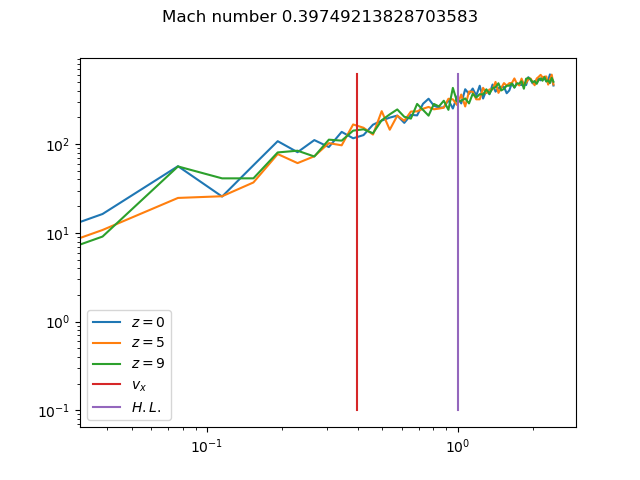

In [34]:

vx_planewave = vx 
hl=1/1
ind=0
ind1=5
ind2=9


d=0.1

plt.figure()

suptitle('Mach number '+ str(vx_planewave))


plot(r,np.real(Eci[ind]),label = r'$z='+str(ind)+'$')
plot(r,np.real(Eci[ind1]),label = r'$z='+str(ind1)+'$')
plot(r,np.real(Eci[ind2]),label = r'$z='+str(ind2)+'$')
#plot(r,Eci[20])
#plot(r,5e5*r**(-5/3),':',label=r'$k^{-5/3}$')
#plot(r,30e2*r**(-11/3),'--',label=r'$k^{-4}$')
#plot(r,30e2*r**(-4),'--',label=r'$k^{-4}$')
#plot(r,30e2*r**(-3),'--',label=r'$k^{-4}$')
#plot(r,2*30e4*r**(-3),'--',label=r'$k^{-3}$')
#plot(r,1e6*r**(-1),'--',label=r'$k^{-1}$')
plot([vx_planewave,vx_planewave],[1e-1,max(Eci[ind])],label=r'$v_x$')
plot([hl,hl],[1e-1,max(Eci[ind])],label=r'$H.L.$')
legend(loc=3)
ax=plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')


# #figure(29)



# x_x = arange(0,ix2-ix1)
# y_y = arange(0,iy2-iy1)
# x_x,y_y = meshgrid(x_x,y_y, indexing='ij') 

# subplot(3,3,2)
# title(r'$z='+str(ind)+'$')
# xticks([])
# yticks([])
# imshow(transpose(abs(simulation_data[ind,ix1:ix2,iy1:iy2])),aspect='auto')
# colorbar()
# subplot(3,3,3)
# title(r'$z='+str(ind)+'$')
# xticks([])
# yticks([])
# #imshow(transpose(angle(simulation_data[ind,ix1:ix2,iy1:iy2])),cmap="PuOr",aspect='auto')
# imshow(transpose(abs(simulation_data[ind,ix1:ix2,iy1:iy2]+1)),cmap="PuOr",aspect='auto')
# streamplot( transpose(x_x), transpose(y_y),transpose(px2[ind,0,ix1:ix2,iy1:iy2]), transpose(px2[ind,1,ix1:ix2,iy1:iy2]),color='k',linewidth=0.5,density=d,arrowsize=0.5)
# colorbar()

# subplot(3,3,5)
# title(r'$z='+str(ind1)+'$')
# imshow(transpose(abs(simulation_data[ind1,ix1:ix2,iy1:iy2])),aspect='auto')
# colorbar()
# xticks([])
# yticks([])
# subplot(3,3,6)
# title(r'$z='+str(ind1)+'$')
# imshow(transpose(angle(simulation_data[ind1,ix1:ix2,iy1:iy2])),cmap="PuOr",aspect='auto')
# streamplot( transpose(x_x), transpose(y_y),transpose(px2[ind1,0,ix1:ix2,iy1:iy2]), transpose(px2[ind1,1,ix1:ix2,iy1:iy2]),color='k',linewidth=0.5,density=d,arrowsize=0.5)

# colorbar()
# xticks([])
# yticks([])

# subplot(3,3,8)
# title(r'$z='+str(ind2)+'$')
# imshow(transpose(abs(simulation_data[ind2,ix1:ix2,iy1:iy2])),aspect='auto')
# colorbar()
# yticks([])
# xticks([])
# subplot(3,3,9)
# title(r'$z='+str(ind2)+'$')
# #imshow(transpose(angle(simulation_data[ind2,ix1:ix2,iy1:iy2])),cmap="PuOr",aspect='auto')
# imshow(transpose(abs(simulation_data[ind2,ix1:ix2,iy1:iy2]+3)),cmap="PuOr",aspect='auto')
# #streamplot( transpose(x_x), transpose(y_y),transpose(px2[ind2,0,ix1:ix2,iy1:iy2]), transpose(px2[ind2,1,ix1:ix2,iy1:iy2]),color='k',linewidth=0.5,density=d,arrowsize=0.5)
# colorbar()
# yticks([])
# xticks([])

Text(0.5, 0, '$v$')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
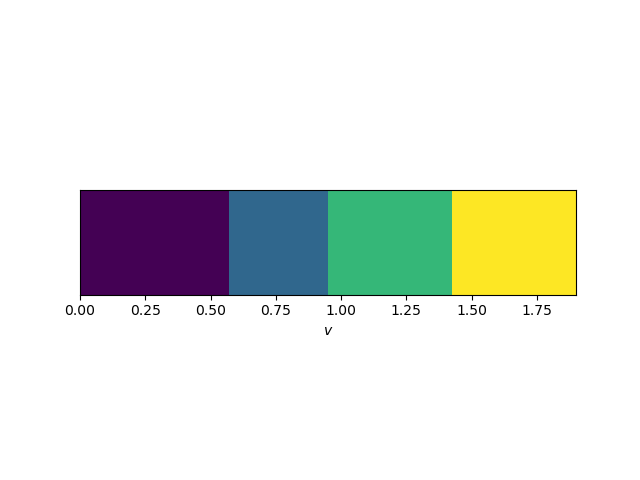

In [27]:
x_r = np.arange(0,2,0.1)
y_r = np.arange(0,0.5,0.1)
xx_r, yy_r = meshgrid(x_r,y_r)
subplots()
region1 = (xx_r>0.5)*(xx_r<1)
region2 = (xx_r>=1)*(xx_r<1.5)
region3 = (xx_r>=1.5)*(xx_r<2)
regions = region1*1+region2*2+region3*3
imshow(regions,extent=[x_r[0],x_r[-1],y_r[0],y_r[-1]])
yticks([])
xlabel(r"$v$")